# compact_PIV tutorial

This tutorial gives examples of constructing `compact_PIV` instances and retrieve PIV data using it. 

The idea: More compact PIV data storage

Currently, PIV data are stored in separate text files. A text file corresponds to a pair of frames. This leads to large file number when we have long videos. However, not all the information in the files are useful. For example, the x, y information are repetitive in all the N text files. Instead of keeping N copies, we can just keep 1 to save storage space. Moreover, the mask information is also repetitive. Therefore, we can seek more compact format to store PIV data. 

The compact data structure makes it less straightforward to access PIV data, due to the fact that x, y and u, v are not in the same shape, and we have to specify the index carefully to avoid making mistakes. I think it makes sense to write a class of `compact_PIV`, which defines the conversion between traditional PIV data structure and compact PIV data structure, and make retrieving data easier.

## 0 Packages

In [15]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
from io import BytesIO
from myimagelib import compact_PIV, readdata
from skimage.io import imread
import zipfile
import matplotlib.pyplot as plt
import requests
from scipy.io import loadmat

In [11]:
# download the test data
url = r"  https://drive.google.com/uc?export=download&id=12qHZ5Zx2idJTBohJEmA66uMPy5xTOl-_"
response = requests.get(url, stream=True)

# Download the zip file
zip_path = "data.zip"
with open(zip_path, "wb") as f:
    f.write(response.content)

# extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("PIV")

os.remove(zip_path)

## 1. Construct `compact_PIV` 

- from conventional PIV data filelist

In [13]:
l = readdata("PIV", "csv")
cpiv = compact_PIV(l)

- from a saved .mat file

In [16]:
cpiv_dict = loadmat(r"PIV\cpiv.mat")
cpiv = compact_PIV(cpiv_dict)

## 2. Retrieve data from `compact_PIV` instance

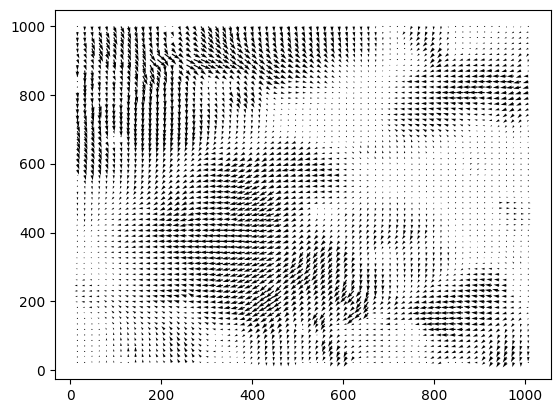

In [17]:
x, y, u, v = cpiv.get_frame(0, by="index")
plt.quiver(x, y, u, v)

In [18]:
cpiv.get_labels()

[np.str_('00000-00001'), np.str_('00002-00003'), np.str_('00004-00005')]

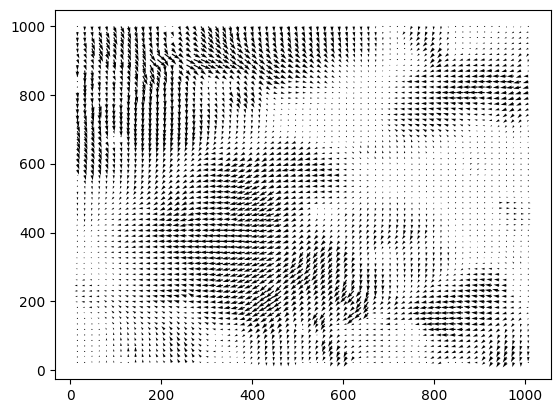

In [20]:
x, y, u, v = cpiv.get_frame("00000-00001", by="label")
plt.quiver(x, y, u, v)

## 3. Save data to .mat file

We can use the Matlab .mat file to save the PIV data. It has two advantages:

- it has no dimension restriction, so we can save x, y, mask data only once
- save one file for an image sequence, instead of one file per image, making the data more portable and maintainable
- easier to interface with Matlab users

In [21]:
cpiv.to_mat(r"PIV\cpiv.mat")

## 4. Update mask

Sometimes we want to update the mask in compact_PIV object. The idea is that (i) the original mask may include regions where image quality is bad, e.g. the bottom shadow region of droplet xz images; (ii) Sometimes we do not have access to the correct mask and we want to apply it later on. 

In these cases, we usually realize the problem after performing the PIV. And to refine the PIV data, we want to update the mask to make it more conservative (i.e. mask out the bad quality region). Therefore, a method is needed to update the "mask" entry in a compact_PIV object.

In [22]:
cpiv.keys

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y', 'u', 'v', 'labels'])

It can be seen that currently we do not have "mask" entry in the `cpiv` object. Now we are going to add one, using `update_mask`. We will use the mask below:

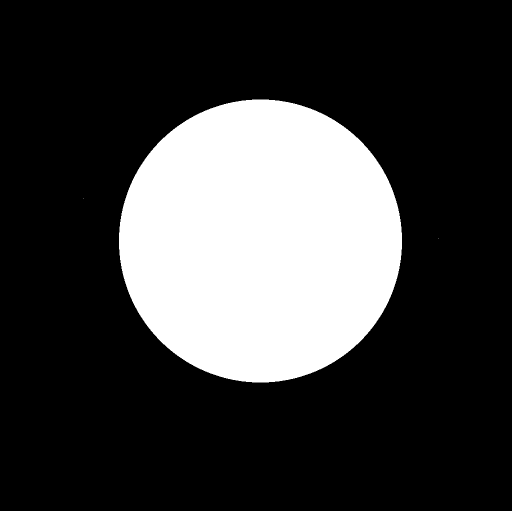

In [24]:
mask = imread(r"PIV\mask.tif")
cpiv.update_mask(mask)
cpiv.keys

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y', 'u', 'v', 'labels', 'mask'])

The masked velocity field can then be accessed:

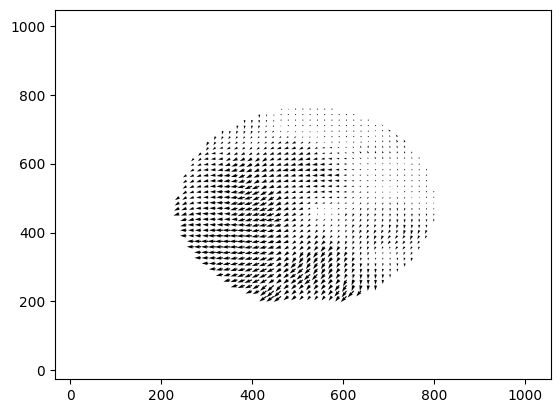

In [25]:
x, y, u, v = cpiv.get_frame(0)
plt.quiver(x, y, u, v)

## 5. Save to csv

Sometimes we want to unpack the .mat data back to the .csv sequence. For example, when the packed .mat is not finished, we can unpack so that the PIV script will not have to redo all the computation, but can pick up the job from the middle. 

In [26]:
cpiv_dict = loadmat(r"PIV\cpiv.mat")
cpiv = compact_PIV(cpiv_dict)
cpiv.to_csv("PIV")